In [1]:
%pip install --quiet dibs-lib 

Note: you may need to restart the kernel to use updated packages.


In [3]:
"""
Ensemble Experiments for Causal Discovery with Interventional Data (Principled Approach)

This script compares SVGD and Deep Ensembles on their ability to recover
a causal graph when trained and evaluated on a mix of observational and
single-target interventional data.

This updated version includes a section for sampling from and plotting
interventional distributions from the ground truth and learned models.
"""

import jax
import jax.random as random
import jax.tree_util
import numpy as np
import time
import functools
import jax.numpy as jnp
import igraph as ig
import matplotlib.pyplot as plt
from jax import vmap, jit

from dibs.target import make_synthetic_bayes_net, make_graph_model
from dibs.models import DenseNonlinearGaussian
from dibs.inference import JointDiBS
from dibs.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood


In [18]:
def create_interventional_data(key, n_vars, n_observations, n_ho_observations, n_intervention_sets, perc_intervened):
    """
    Generates synthetic data, combining observational and interventional for training,
    but keeping observational and interventional held-out sets separate.
    """
    print("\n" + "="*70)
    print("1. GENERATING GROUND TRUTH DATA")
    print("="*70)

    key, subk = random.split(key)

    # Define graph model and generative/likelihood models
    # The generative_model is used to create the ground truth data
    # The likelihood_model is used by DiBS for inference
    graph_model = make_graph_model(n_vars=n_vars, graph_prior_str="sf")
    generative_model = DenseNonlinearGaussian(
        n_vars=n_vars, hidden_layers=(5,), obs_noise=0.1, sig_param=1.0)
    likelihood_model = DenseNonlinearGaussian(
        n_vars=n_vars, hidden_layers=(5,), obs_noise=0.1, sig_param=1.0)

    # Generate all intervention sets and observational data
    data = make_synthetic_bayes_net(
        key=subk, n_vars=n_vars, graph_model=graph_model, generative_model=generative_model,
        n_observations=n_observations, n_ho_observations=n_ho_observations,
        n_intervention_sets=n_intervention_sets, perc_intervened=perc_intervened)

    # --- Create Combined Training Dataset ---
    # Start with observational data
    all_train_data = [data.x]
    all_train_masks = [jnp.zeros_like(data.x, dtype=bool)]

    # Add first (n_intervention_sets-1) interventional datasets for training
    for i in range(n_intervention_sets - 1):
        interv_dict, interv_x_train = data.x_interv[i]
        all_train_data.append(interv_x_train)
        
        # Create intervention mask
        mask_train_interv = jnp.zeros_like(interv_x_train, dtype=bool)
        intervened_nodes = list(interv_dict.keys())
        mask_train_interv = mask_train_interv.at[:, intervened_nodes].set(True)
        all_train_masks.append(mask_train_interv)

    # Finalize training set
    x_train = jnp.concatenate(all_train_data, axis=0)
    mask_train = jnp.concatenate(all_train_masks, axis=0)

    # --- Prepare Held-Out Sets ---
    # Observational held-out (already available)
    x_ho_obs = data.x_ho

    # Interventional held-out (use last intervention set)
    interv_dict_ho, x_ho_intrv = data.x_interv[-1]
    mask_ho_intrv = jnp.zeros_like(x_ho_intrv, dtype=bool)
    intervened_nodes_ho = list(interv_dict_ho.keys())
    mask_ho_intrv = mask_ho_intrv.at[:, intervened_nodes_ho].set(True)

    print(f"Ground truth graph generated.")
    print(f"\nTotal training samples: {x_train.shape[0]} (observational + {n_intervention_sets-1} interventional sets)")
    print(f"Held-out observational samples: {x_ho_obs.shape[0]}")
    print(f"Held-out interventional samples: {x_ho_intrv.shape[0]}")

    # Return the `data` object which contains ground truth graph and parameters
    return (x_train, mask_train, x_ho_obs, x_ho_intrv, mask_ho_intrv,
            data.g, graph_model, likelihood_model,generative_model, data )


In [5]:
def compute_metrics(dist, name, dibs_instance, x_ho, mask_ho, g_true):
    """Computes and prints metrics for a given particle distribution."""
    eshd = expected_shd(dist=dist, g=g_true)
    auroc = threshold_metrics(dist=dist, g=g_true)['roc_auc']
    
    # Compute negative average log-likelihood
    negll = neg_ave_log_likelihood(
        dist=dist, 
        eltwise_log_likelihood=lambda g, theta: dibs_instance.likelihood_model.log_prob(g=g, theta=theta, x=x_ho, interv_mask=mask_ho),
        x=None
    )

    print(f'{name:25s} | E-SHD: {eshd:5.2f}  AUROC: {auroc:5.3f}  NegLL: {negll:7.2f}')
    return {'eshd': eshd, 'auroc': auroc, 'negll': negll}


# Parameters

In [9]:
N_PARTICLES = 20
N_ENSEMBLE_RUNS = 20
N_STEPS = 10

key = random.PRNGKey(42)
print(f"JAX backend: {jax.default_backend()}")


JAX backend: cpu


# Generate Data

In [19]:
# 1. Generate Data
(x_train, mask_train, x_ho_obs, x_ho_intrv, mask_ho_intrv,
 g_true, graph_model, likelihood_model, generative_model, data) = create_interventional_data(
    key=key, n_vars=20, n_observations=100, n_ho_observations=100,
    n_intervention_sets=3, perc_intervened=0.1)



1. GENERATING GROUND TRUTH DATA
Ground truth graph generated.

Total training samples: 300 (observational + 2 interventional sets)
Held-out observational samples: 100
Held-out interventional samples: 100


# SVGD traning

In [11]:
print("\n" + "="*70)
print(f"3. SVGD BASELINE (1 run x {N_PARTICLES} particles)")
print("="*70)
key, subk = random.split(key)
dibs_svgd = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)

start_time = time.time()
gs_svgd, thetas_svgd = dibs_svgd.sample(key=subk, n_particles=N_PARTICLES, steps=N_STEPS)
svgd_time = time.time() - start_time

svgd_mixture = dibs_svgd.get_mixture(gs_svgd, thetas_svgd)
print(f"Finished in {svgd_time:.2f}s")



3. SVGD BASELINE (1 run x 20 particles)
Finished in 38.72s


# Deep ensemble training

In [12]:
print("\n" + "="*70)
print(f"4. DEEP ENSEMBLE ({N_ENSEMBLE_RUNS} runs x 1 particle)")
print("="*70)
ensemble_gs = []
ensemble_thetas = []

ensemble_start = time.time()
for i in range(N_ENSEMBLE_RUNS):
    print(f"Run {i+1}/{N_ENSEMBLE_RUNS}", end=" ")
    key, subk = random.split(key)
    dibs_single = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)
    gs, thetas = dibs_single.sample(key=subk, n_particles=1, steps=N_STEPS)
    
    ensemble_gs.append(gs)
    ensemble_thetas.append(thetas)
    print("✓")
ensemble_time = time.time() - ensemble_start

combined_gs = np.concatenate(ensemble_gs, axis=0)
combined_thetas = jax.tree_util.tree_map(lambda *arrays: np.concatenate(arrays, axis=0), *ensemble_thetas)

dibs_ensemble = JointDiBS(x=x_train, interv_mask=mask_train, graph_model=graph_model, likelihood_model=likelihood_model)
true_ensemble_mixture = dibs_ensemble.get_mixture(combined_gs, combined_thetas)
print(f"Finished in {ensemble_time:.2f}s")




4. DEEP ENSEMBLE (20 runs x 1 particle)
Run 1/20 ✓
Run 2/20 ✓
Run 3/20 ✓
Run 4/20 ✓
Run 5/20 ✓
Run 6/20 ✓
Run 7/20 ✓
Run 8/20 ✓
Run 9/20 ✓
Run 10/20 ✓
Run 11/20 ✓
Run 12/20 ✓
Run 13/20 ✓
Run 14/20 ✓
Run 15/20 ✓
Run 16/20 ✓
Run 17/20 ✓
Run 18/20 ✓
Run 19/20 ✓
Run 20/20 ✓
Finished in 116.39s


# Evaluation

In [13]:
print("\n" + "="*70)
print("5. EVALUATION")
print("="*70)

svgd_eshd = expected_shd(dist=svgd_mixture, g=g_true)
svgd_auroc = threshold_metrics(dist=svgd_mixture, g=g_true)['roc_auc']
ens_eshd = expected_shd(dist=true_ensemble_mixture, g=g_true)
ens_auroc = threshold_metrics(dist=true_ensemble_mixture, g=g_true)['roc_auc']

print("--- 5a. On OBSERVATIONAL Held-Out Data ---")
svgd_negll_obs = neg_ave_log_likelihood(
    dist=svgd_mixture,
    eltwise_log_likelihood=dibs_svgd.eltwise_log_likelihood_observ,
    x=x_ho_obs
)
ens_negll_obs = neg_ave_log_likelihood(
    dist=true_ensemble_mixture,
    eltwise_log_likelihood=dibs_ensemble.eltwise_log_likelihood_observ,
    x=x_ho_obs
)
print(f'SVGD Mixture (Obs)      | E-SHD: {svgd_eshd:5.2f}  AUROC: {svgd_auroc:5.3f}  NegLL: {svgd_negll_obs:7.2f}')
print(f'Ensemble Mixture (Obs)  | E-SHD: {ens_eshd:5.2f}  AUROC: {ens_auroc:5.3f}  NegLL: {ens_negll_obs:7.2f}')

print("\n--- 5b. On INTERVENTIONAL Held-Out Data ---")
svgd_negll_intrv = neg_ave_log_likelihood(
    dist=svgd_mixture,
    eltwise_log_likelihood=lambda g, theta, x: dibs_svgd.eltwise_log_likelihood_interv(g, theta, x, mask_ho_intrv),
    x=x_ho_intrv
)
ens_negll_intrv = neg_ave_log_likelihood(
    dist=true_ensemble_mixture,
    eltwise_log_likelihood=lambda g, theta, x: dibs_ensemble.eltwise_log_likelihood_interv(g, theta, x, mask_ho_intrv),
    x=x_ho_intrv
)
print(f'SVGD Mixture (Intrv)    | E-SHD: {svgd_eshd:5.2f}  AUROC: {svgd_auroc:5.3f}  NegLL: {svgd_negll_intrv:7.2f}')
print(f'Ensemble Mixture (Intrv)| E-SHD: {ens_eshd:5.2f}  AUROC: {ens_auroc:5.3f}  NegLL: {ens_negll_intrv:7.2f}')

# --- 6. Summary ---
print("\n" + "="*70)
print("6. SUMMARY")
print("="*70)
print(f"Computation time:")
print(f"  SVGD ({N_PARTICLES} particles):      {svgd_time:6.1f}s")
print(f"  Deep Ensemble ({N_ENSEMBLE_RUNS} × 1):   {ensemble_time:6.1f}s")
print("\n{:<25} | {:>10} | {:>10}".format("Metric", "SVGD", "Ensemble"))
print("-"*51)
print("{:<25} | {:10.2f} | {:10.2f}".format("E-SHD", svgd_eshd, ens_eshd))
print("{:<25} | {:10.3f} | {:10.3f}".format("AUROC", svgd_auroc, ens_auroc))
print("{:<25} | {:10.2f} | {:10.2f}".format("NLL (Observational)", svgd_negll_obs, ens_negll_obs))
print("{:<25} | {:10.2f} | {:10.2f}".format("NLL (Interventional)", svgd_negll_intrv, ens_negll_intrv))
print("="*70)




5. EVALUATION
--- 5a. On OBSERVATIONAL Held-Out Data ---
SVGD Mixture (Obs)      | E-SHD: 190.00  AUROC: 0.500  NegLL: 5164093.50
Ensemble Mixture (Obs)  | E-SHD: 190.00  AUROC: 0.500  NegLL: 5164093.50

--- 5b. On INTERVENTIONAL Held-Out Data ---
SVGD Mixture (Intrv)    | E-SHD: 190.00  AUROC: 0.500  NegLL: 5232720.00
Ensemble Mixture (Intrv)| E-SHD: 190.00  AUROC: 0.500  NegLL: 5232720.00

6. SUMMARY
Computation time:
  SVGD (20 particles):        38.7s
  Deep Ensemble (20 × 1):    116.4s

Metric                    |       SVGD |   Ensemble
---------------------------------------------------
E-SHD                     |     190.00 |     190.00
AUROC                     |      0.500 |      0.500
NLL (Observational)       | 5164093.50 | 5164093.50
NLL (Interventional)      | 5232720.00 | 5232720.00


In [ ]:
print("\n" + "="*70)
print("7. SAVING RESULTS TO experiment_results.csv")
print("="*70)

results_path = "experiment_results.csv"
with open(results_path, "w") as f:
    f.write("Method,ESHD,AUROC,NLL_Observational,NLL_Interventional,Time_sec\n")
    f.write(f"SVGD,{svgd_eshd:.4f},{svgd_auroc:.4f},{svgd_negll_obs:.2f},{svgd_negll_intrv:.2f},{svgd_time:.2f}\n")
    f.write(f"Ensemble,{ens_eshd:.4f},{ens_auroc:.4f},{ens_negll_obs:.2f},{ens_negll_intrv:.2f},{ensemble_time:.2f}\n")
print(f"Results successfully saved to {results_path}")

# --- 8. Interventional Distribution Comparison ---
print("\n" + "="*70)
print("8. COMPARING INTERVENTIONAL DISTRIBUTIONS")
print("="*70)


# Interventional Distribution Comparison
Setting up. Find a strong link within the ground truth


Selected strongest edge: intervene on x_14, observe x_15 (strength 0.9526)

Sampling p(X_15) (observational, no intervention) from ground truth.

Sampling p(X_15 | do(X_14 = 0.0)) from ground truth.


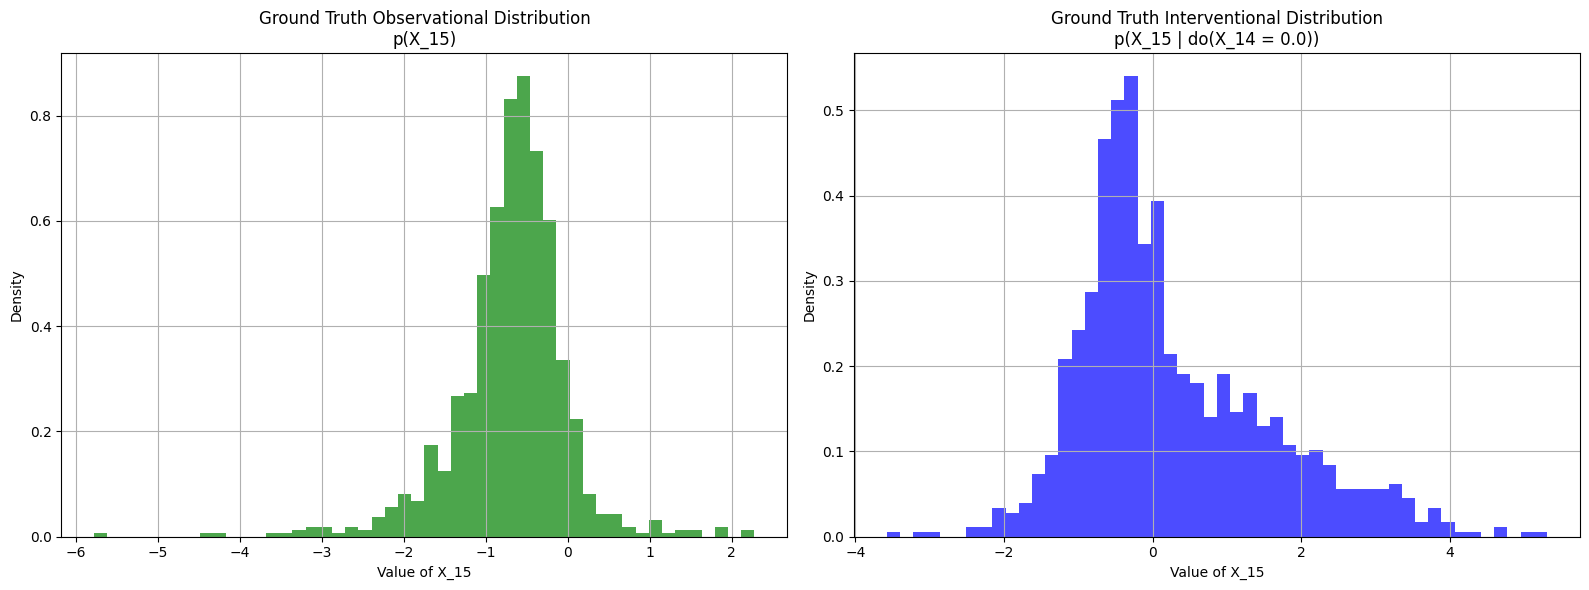

In [ ]:
# Parameters for assessment and sampling
n_assess_samples = 100  # Samples to assess effect strength
n_interv_samples = 100  # Samples for final histogram
interv_value = 0.0

# Convert to numpy for easier manipulation
import numpy as np
g_true_np = np.array(data.g)
theta_np = data.theta  # PyTree, but we don't use it for weights

# Create igraph for sampling
g_true_igraph = ig.Graph.Adjacency(g_true_np.tolist())

# --- Part 1: Find strong links (using sampling to assess causal effect strength) ---
# Find all existing edges: (parent j, child i) where g_true[j, i] == 1
edges = np.argwhere(g_true_np == 1)  # shape [n_edges, 2], each [j, i]

# Measure causal effect strength by difference in mean of X_i with and without do(X_j=0)
effect_strengths = []

for j, i in edges:
    # Sample observational (no intervention)
    key, subk = random.split(key)
    obs_samples = generative_model.sample_obs(
        key=subk,
        n_samples=n_assess_samples,
        g=g_true_igraph,
        theta=theta_np,
        interv=None
    )
    obs_mean = np.mean(obs_samples[:, i])
    
    # Sample interventional do(X_j = interv_value)
    key, subk = random.split(key)
    interv_dict = {j: interv_value}
    interv_samples = generative_model.sample_obs(
        key=subk,
        n_samples=n_assess_samples,
        g=g_true_igraph,
        theta=theta_np,
        interv=interv_dict
    )
    interv_mean = np.mean(interv_samples[:, i])
    
    strength = abs(interv_mean - obs_mean)
    effect_strengths.append(strength)

# Select the strongest edge (largest effect)
if edges.size > 0:
    max_idx = np.argmax(effect_strengths)
    j, i = edges[max_idx]
    print(f"\nSelected strongest edge: intervene on x_{j}, observe x_{i} (strength {effect_strengths[max_idx]:.4f})")
else:
    raise ValueError("No edges in the graph!")

# --- Part 2: Sample observational and interventional distributions ---
# Observational sampling (no intervention)
print(f"\nSampling p(X_{i}) (observational, no intervention) from ground truth.")
key, subk = random.split(key)
gt_obs_samples = generative_model.sample_obs(
    key=subk,
    n_samples=n_interv_samples,
    g=g_true_igraph,
    theta=theta_np,
    interv=None
)

# Interventional sampling
interv_dict = {j: interv_value}
print(f"\nSampling p(X_{i} | do(X_{j} = {interv_value})) from ground truth.")
key, subk = random.split(key)
gt_interv_samples = generative_model.sample_obs(
    key=subk,
    n_samples=n_interv_samples,
    g=g_true_igraph,
    theta=theta_np,
    interv=interv_dict
)

# Plot histograms for comparison
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.7, color='green')
axs[0].set_title(f"Ground Truth Observational Distribution\np(X_{i})")
axs[0].set_xlabel(f"Value of X_{i}")
axs[0].set_ylabel("Density")
axs[0].grid(True)

axs[1].hist(gt_interv_samples[:, i], bins=50, density=True, alpha=0.7, color='blue')
axs[1].set_title(f"Ground Truth Interventional Distribution\np(X_{i} | do(X_{j} = {interv_value}))")
axs[1].set_xlabel(f"Value of X_{i}")
axs[1].set_ylabel("Density")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# For extension to learned models (SVGD and Ensemble), you can adapt this by:
# - Looping over particles (since vmap may not work with igraph)
# - Sampling from each particle's graph and theta
# - Combining all samples across particles for the histogram


In [32]:




# Helper function to sample from a single particle
def sample_from_particle(key, g_matrix, theta, interv):
    g_igraph = ig.Graph.Adjacency(np.array(g_matrix).tolist())  # Convert to numpy then list
    samples_per_particle = n_interv_samples // g_matrix.shape[0]
    return likelihood_model.sample_obs(
        key=key,
        n_samples=samples_per_particle,
        g=g_igraph,
        theta=theta,
        interv=interv
    )

# SVGD: Observational
print("\nSampling observational from SVGD particles.")
svgd_obs_samples_list = []
for p in range(N_PARTICLES):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, gs_svgd[p], thetas_svgd[p], interv=None)
    svgd_obs_samples_list.append(samples[:, i])  # Slice observed node i

svgd_obs_samples = np.concatenate(svgd_obs_samples_list)

# SVGD: Interventional
print("\nSampling interventional from SVGD particles.")
svgd_interv_samples_list = []
for p in range(N_PARTICLES):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, gs_svgd[p], thetas_svgd[p], interv=interv_dict)
    svgd_interv_samples_list.append(samples[:, i])

svgd_interv_samples = np.concatenate(svgd_interv_samples_list)

# Ensemble: Observational
print("\nSampling observational from Ensemble particles.")
ensemble_obs_samples_list = []
for p in range(N_ENSEMBLE_RUNS):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, combined_gs[p], combined_thetas[p], interv=None)
    ensemble_obs_samples_list.append(samples[:, i])

ensemble_obs_samples = np.concatenate(ensemble_obs_samples_list)

# Ensemble: Interventional
print("\nSampling interventional from Ensemble particles.")
ensemble_interv_samples_list = []
for p in range(N_ENSEMBLE_RUNS):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, combined_gs[p], combined_thetas[p], interv=interv_dict)
    ensemble_interv_samples_list.append(samples[:, i])

ensemble_interv_samples = np.concatenate(ensemble_interv_samples_list)

# Plot all distributions for comparison
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Ground Truth Observational
axs[0, 0].hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.7, color='green')
axs[0, 0].set_title(f"Ground Truth Observational\np(X_{i})")
axs[0, 0].set_xlabel


Sampling observational from SVGD particles.


InternalError: Error at src/properties/dag.c:125: The graph has cycles; topological sorting is only possible in acyclic graphs. -- Invalid value

In [33]:

# --- Extension: Sample from Learned Models (SVGD and Ensemble) ---
# Use loops instead of vmap to avoid tracing issues with igraph

# Helper function to sample from a single particle
def sample_from_particle(key, g_matrix, theta, interv):
    g_igraph = ig.Graph.Adjacency(np.array(g_matrix).tolist())  # Convert to numpy then list
    samples_per_particle = n_interv_samples // g_matrix.shape[0]
    return likelihood_model.sample_obs(
        key=key,
        n_samples=samples_per_particle,
        g=g_igraph,
        theta=theta,
        interv=interv
    )

# SVGD: Observational
print("\nSampling observational from SVGD particles.")
svgd_obs_samples_list = []
for p in range(N_PARTICLES):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, gs_svgd[p], thetas_svgd[p], interv=None)
    svgd_obs_samples_list.append(samples[:, i])  # Slice observed node i

svgd_obs_samples = np.concatenate(svgd_obs_samples_list)

# SVGD: Interventional
print("\nSampling interventional from SVGD particles.")
svgd_interv_samples_list = []
for p in range(N_PARTICLES):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, gs_svgd[p], thetas_svgd[p], interv=interv_dict)
    svgd_interv_samples_list.append(samples[:, i])

svgd_interv_samples = np.concatenate(svgd_interv_samples_list)

# Ensemble: Observational
print("\nSampling observational from Ensemble particles.")
ensemble_obs_samples_list = []
for p in range(N_ENSEMBLE_RUNS):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, combined_gs[p], combined_thetas[p], interv=None)
    ensemble_obs_samples_list.append(samples[:, i])

ensemble_obs_samples = np.concatenate(ensemble_obs_samples_list)

# Ensemble: Interventional
print("\nSampling interventional from Ensemble particles.")
ensemble_interv_samples_list = []
for p in range(N_ENSEMBLE_RUNS):
    key, subk = random.split(key)
    samples = sample_from_particle(subk, combined_gs[p], combined_thetas[p], interv=interv_dict)
    ensemble_interv_samples_list.append(samples[:, i])

ensemble_interv_samples = np.concatenate(ensemble_interv_samples_list)

# Plot learned distributions (4 plots as requested)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# SVGD Observational
axs[0, 0].hist(svgd_obs_samples, bins=50, density=True, alpha=0.7, color='orange')
axs[0, 0].set_title(f"SVGD Observational Distribution\np(X_{i})")
axs[0, 0].set_xlabel(f"Value of X_{i}")
axs[0, 0].set_ylabel("Density")
axs[0, 0].grid(True)

# SVGD Interventional
axs[0, 1].hist(svgd_interv_samples, bins=50, density=True, alpha=0.7, color='red')
axs[0, 1].set_title(f"SVGD Interventional Distribution\np(X_{i} | do(X_{j} = {interv_value}))")
axs[0, 1].set_xlabel(f"Value of X_{i}")
axs[0, 1].set_ylabel("Density")
axs[0, 1].grid(True)

# Ensemble Observational
axs[1, 0].hist(ensemble_obs_samples, bins=50, density=True, alpha=0.7, color='purple')
axs[1, 0].set_title(f"Ensemble Observational Distribution\np(X_{i})")
axs[1, 0].set_xlabel(f"Value of X_{i}")
axs[1, 0].set_ylabel("Density")
axs[1, 0].grid(True)

# Ensemble Interventional
axs[1, 1].hist(ensemble_interv_samples, bins=50, density=True, alpha=0.7, color='magenta')
axs[1, 1].set_title(f"Ensemble Interventional Distribution\np(X_{i} | do(X_{j} = {interv_value}))")
axs[1, 1].set_xlabel(f"Value of X_{i}")
axs[1, 1].set_ylabel("Density")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Optional: Combined comparison plots
# Observational comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(gt_obs_samples[:, i], bins=50, density=True, alpha=0.5, label='Ground Truth', color='green')
ax.hist(svgd_obs_samples, bins=50, density=True, alpha=0.5, label='SVGD', color='orange')
ax.hist(ensemble_obs_samples, bins=50, density=True, alpha=0.5, label='Ensemble', color='purple')
ax.set_title(f"Observational Distribution Comparison\np(X_{i})")
ax.set_xlabel(f"Value of X_{i}")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True)
plt.show()

# Interventional comparison
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(gt_interv_samples[:, i], bins=50, density=True, alpha=0.5, label='Ground Truth', color='blue')
ax.hist(svgd_interv_samples, bins=50, density=True, alpha=0.5, label='SVGD', color='red')
ax.hist(ensemble_interv_samples, bins=50, density=True, alpha=0.5, label='Ensemble', color='magenta')
ax.set_title(f"Interventional Distribution Comparison\np(X_{i} | do(X_{j} = {interv_value}))")
ax.set_xlabel(f"Value of X_{i}")
ax.set_ylabel("Density")
ax.legend()
ax.grid(True)
plt.show()




Sampling observational from SVGD particles.


InternalError: Error at src/properties/dag.c:125: The graph has cycles; topological sorting is only possible in acyclic graphs. -- Invalid value